In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)

if inspector.has_table("measurement"):
    # Get columns information
    columns = inspector.get_columns("measurement")
    for c in columns:
        print(c["name"], c["type"])
else:
    print("Table 'measurement' not found.")

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# recent date
recent_date = session.query(measurement).order_by(measurement.date.desc()).first()
recent_date_str = recent_date.date
recent_date_str

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_dt = dt.datetime.strptime(recent_date_str, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
year_ago_dt = recent_date_dt - dt.timedelta(days=365)

year_ago_str = str(year_ago_dt)
year_ago_str

# Perform a query to retrieve the data and precipitation scores

recent_year = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date >= year_ago_str).\
    filter(measurement.date <= recent_date_str).\
    order_by(measurement.date)
recent_year_sql = str(recent_year)


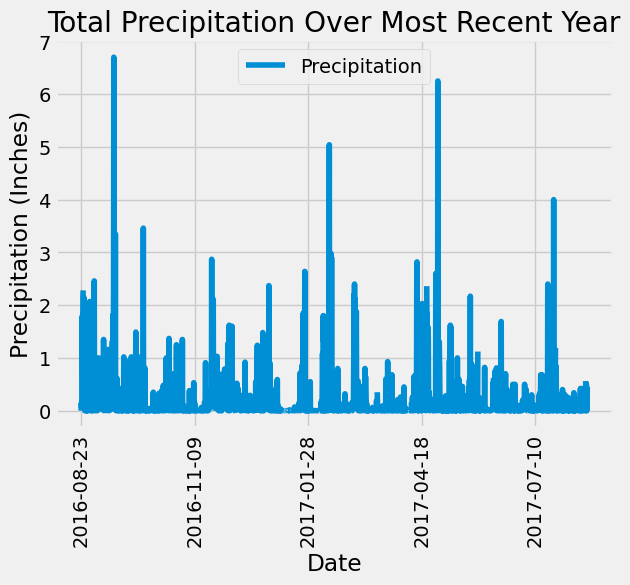

In [12]:

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.read_sql(recent_year_sql, engine, params=(year_ago_str, recent_date_str))
precipitation_df = precipitation_df.rename(columns={"measurement_prcp": "Precipitation", 
                                                    "measurement_date": "Date"})

# Sort the dataframe by date
precipitation_df = precipitation_df.set_index(["Date"])
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Total Precipitation Over Most Recent Year")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns("station")

session.query(func.count(station.station)).all()


[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(station.name).all()
station_activity = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by((func.count(measurement.station)).desc()).\
    all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = list(np.ravel(station_activity))
most_active = most_active[0]
session.query(func.min(measurement.tobs), func.max(measurement.tobs),
                                       func.avg(measurement.tobs)).filter(measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

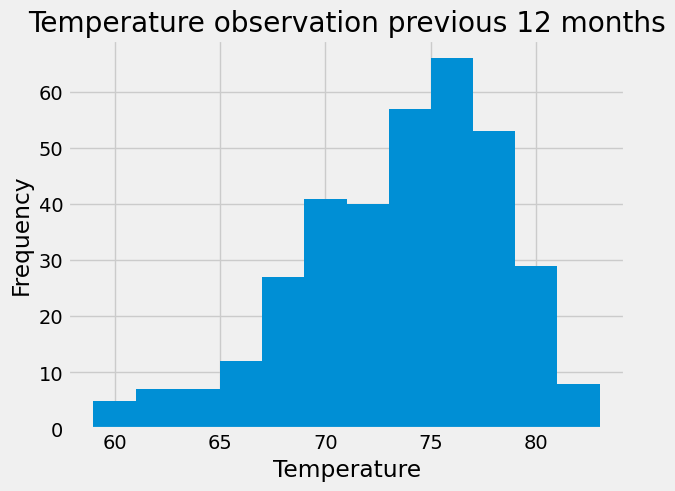

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_query = session.query(measurement.tobs, func.count(measurement.tobs)).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= year_ago_str).\
    filter(measurement.date <= recent_date_str).\
    group_by(measurement.tobs).\
    order_by((func.count(measurement.tobs)).desc())
most_active_station_sql = str(most_active_query)

most_active_station_df = pd.read_sql(most_active_station_sql, engine, params=(most_active, year_ago_str, recent_date_str))
most_active_station_df = most_active_station_df.rename(columns={"measurement_tobs": "Temperature", 
                                                    "count_1": "Frequency"})
# data frame plot

plt.hist(most_active_station_df.Temperature, weights=most_active_station_df.Frequency, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature observation previous 12 months")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()